In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/forskningsmetodik/data_12_04 (1).zip" -d "/content/"

Archive:  /content/drive/MyDrive/forskningsmetodik/data_12_04 (1).zip
   creating: /content/data_12_04/
   creating: /content/data_12_04/images/
  inflating: /content/data_12_04/images/Pos101_img_000000000.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000001.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000002.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000003.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000004.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000005.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000006.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000007.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000008.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000009.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000010.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000011.tiff  
  inflating: /content/data_12_04/images

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology, segmentation, feature, measure
from scipy import ndimage as ndi
import random
from PIL import Image
from skimage.feature import peak_local_max

In [ ]:
masks_p = glob.glob("/content/data_12_04/masks/*")
masks_p = sorted(masks_p)

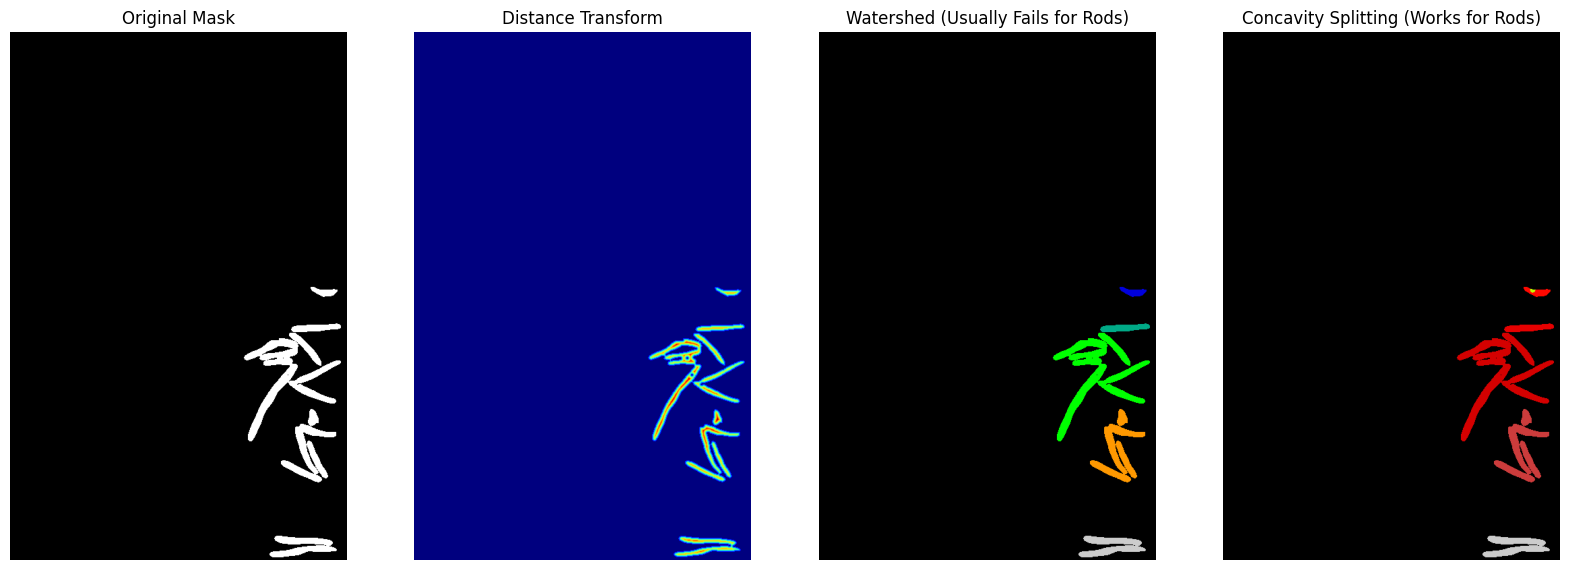

In [ ]:
import numpy as np
import cv2
from scipy import ndimage as ndi
from skimage import measure, morphology, segmentation
from matplotlib import pyplot as plt
from PIL import Image
import random

random_mask = Image.open(random.choice(masks_p))
random_mask = np.array(random_mask)
binary = (random_mask > 0).astype(np.uint8)

def split_by_concavity(binary_mask):
    cnts, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    result = np.zeros_like(binary_mask, dtype=np.uint16)
    label_id = 1

    for c in cnts:
        hull = cv2.convexHull(c, returnPoints=False)
        if hull is None or len(hull) < 3:
            continue

        defects = cv2.convexityDefects(c, hull)

        if defects is None:
            cv2.drawContours(result, [c], -1, label_id, -1)
            label_id += 1
            continue

        depths = defects[:,0,3]
        idx = np.argmax(depths)
        s, e, f, d = defects[idx,0]
        concave = tuple(c[f][0])

        cut_mask = binary_mask.copy()
        cv2.circle(cut_mask, concave, radius=4, color=0, thickness=-1)

        parts = measure.label(cut_mask)

        for pid in np.unique(parts)[1:]:
            region = (parts == pid).astype(np.uint8)
            result[region == 1] = label_id
            label_id += 1

    return result

dist = ndi.distance_transform_edt(binary)
skel = morphology.skeletonize(binary)
dist_skel = dist * skel
skel_labels = measure.label(skel)

markers = np.zeros_like(binary, dtype=int)
marker_id = 1

for region in measure.regionprops(skel_labels):
    coords = region.coords
    dvals = dist_skel[coords[:,0], coords[:,1]]
    idx = np.argmax(dvals)
    y, x = coords[idx]
    markers[y, x] = marker_id
    marker_id += 1

ws_labels = segmentation.watershed(-dist, markers, mask=binary)

concavity_labels = split_by_concavity(binary)
f, a = plt.subplots(1, 4, figsize=(20, 20))

a[0].imshow(binary, cmap='gray')
a[0].set_title("Original Mask")

a[1].imshow(dist, cmap='jet')
a[1].set_title("Distance Transform")

a[2].imshow(ws_labels, cmap='nipy_spectral')
a[2].set_title("Watershed (Usually Fails for Rods)")

a[3].imshow(concavity_labels, cmap='nipy_spectral')
a[3].set_title("Concavity Splitting (Works for Rods)")

for ax in a:
    ax.axis('off')

plt.show()

In [ ]:
print(np.unique(random_mask))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


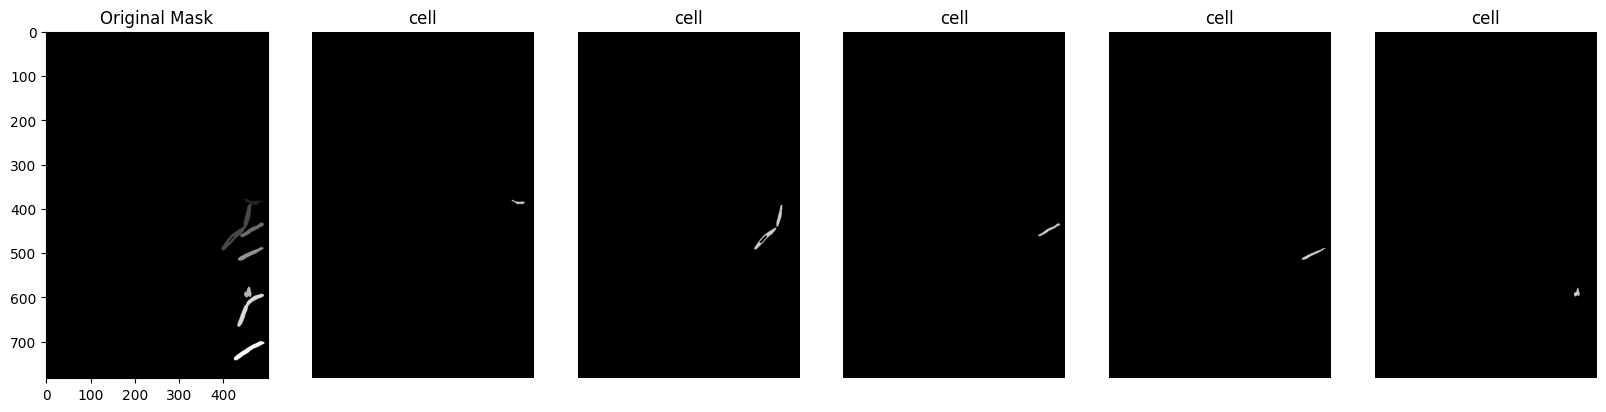

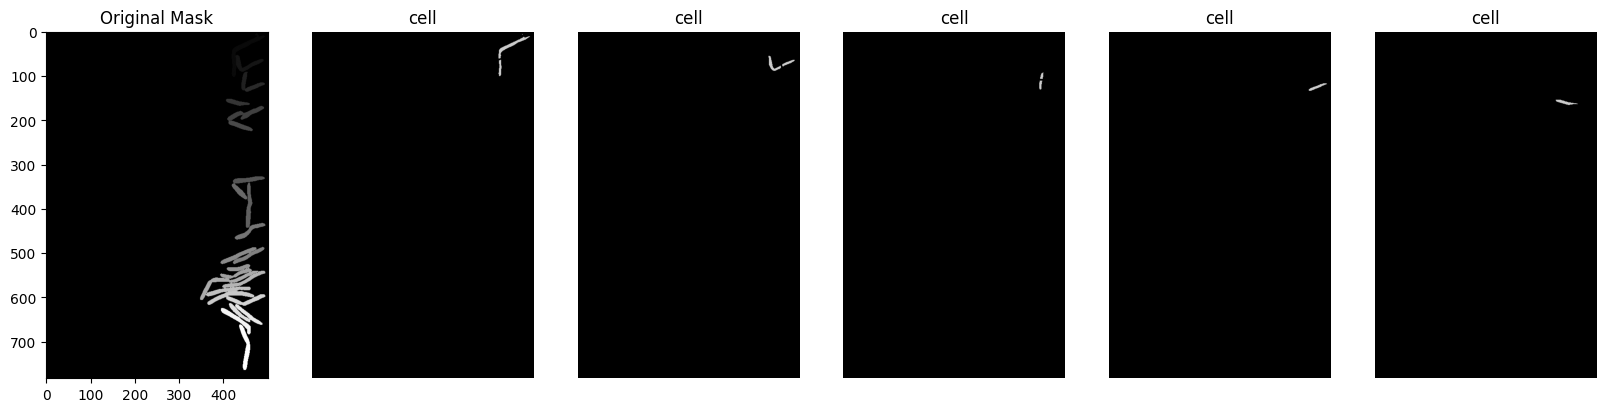

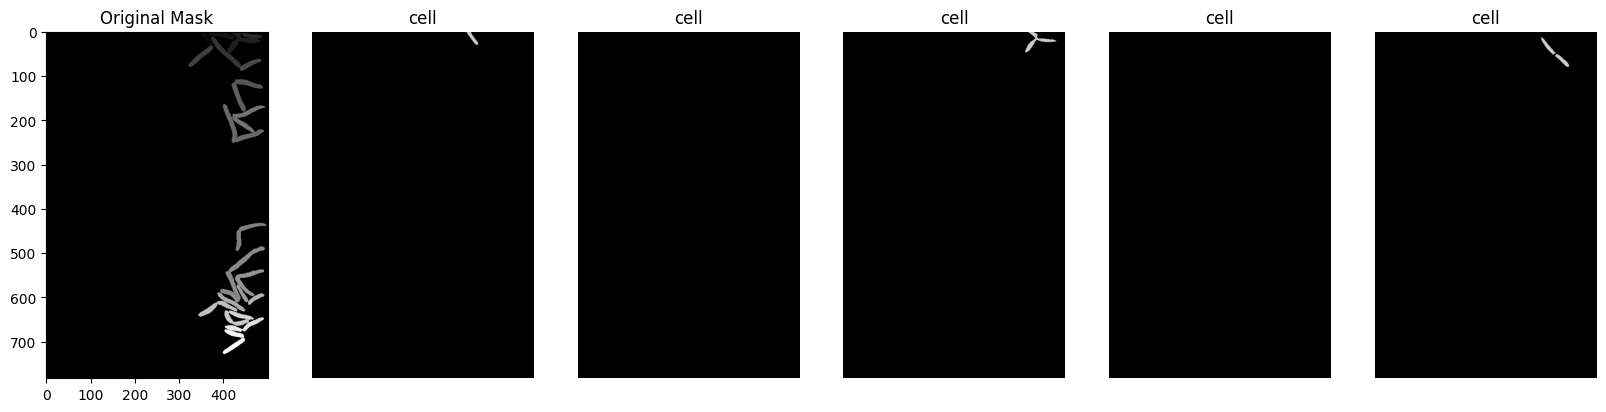

In [ ]:
import numpy as np
import cv2
from skimage import measure, segmentation
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from PIL import Image
import random
from skimage.segmentation import find_boundaries
from scipy.ndimage import binary_dilation
from skimage.morphology import skeletonize
# find boundaries of labeled regions


for i in range(3):
    random_mask = Image.open(random.choice(masks_p))
    random_mask = np.array(random_mask)
    individualcells = len(np.unique(random_mask))

    f, a = plt.subplots(1, 6, figsize=(20, 20))
    a = a.ravel()
    a[0].imshow(random_mask, cmap='gray')
    a[0].set_title("Original Mask")

    for j in range(1, 6):
        subset = (random_mask == j)

        if np.sum(subset) == 0:
            continue

        distance = cv2.distanceTransform(subset.astype(np.uint8), cv2.DIST_L2, 5)
        coords = peak_local_max(
            distance,
            labels=subset,
            min_distance=26
        )

        # coords to markers
        markers = np.zeros_like(distance, dtype=np.int32)
        for idx, (y, x) in enumerate(coords, 1):
            markers[y, x] = idx

        # Watershed
        labels = segmentation.watershed(-distance, markers, mask=subset)
        boundaries = find_boundaries(labels, connectivity=1, mode='thick')
        boundaries = binary_dilation(boundaries, iterations=1)
        labels[boundaries] = 0
        labels = labels > 0

        a[j].imshow(labels, cmap='nipy_spectral')
        a[j].set_title("cell")
        a[j].axis('off')


Text(0.5, 1.0, 'Split Mask')

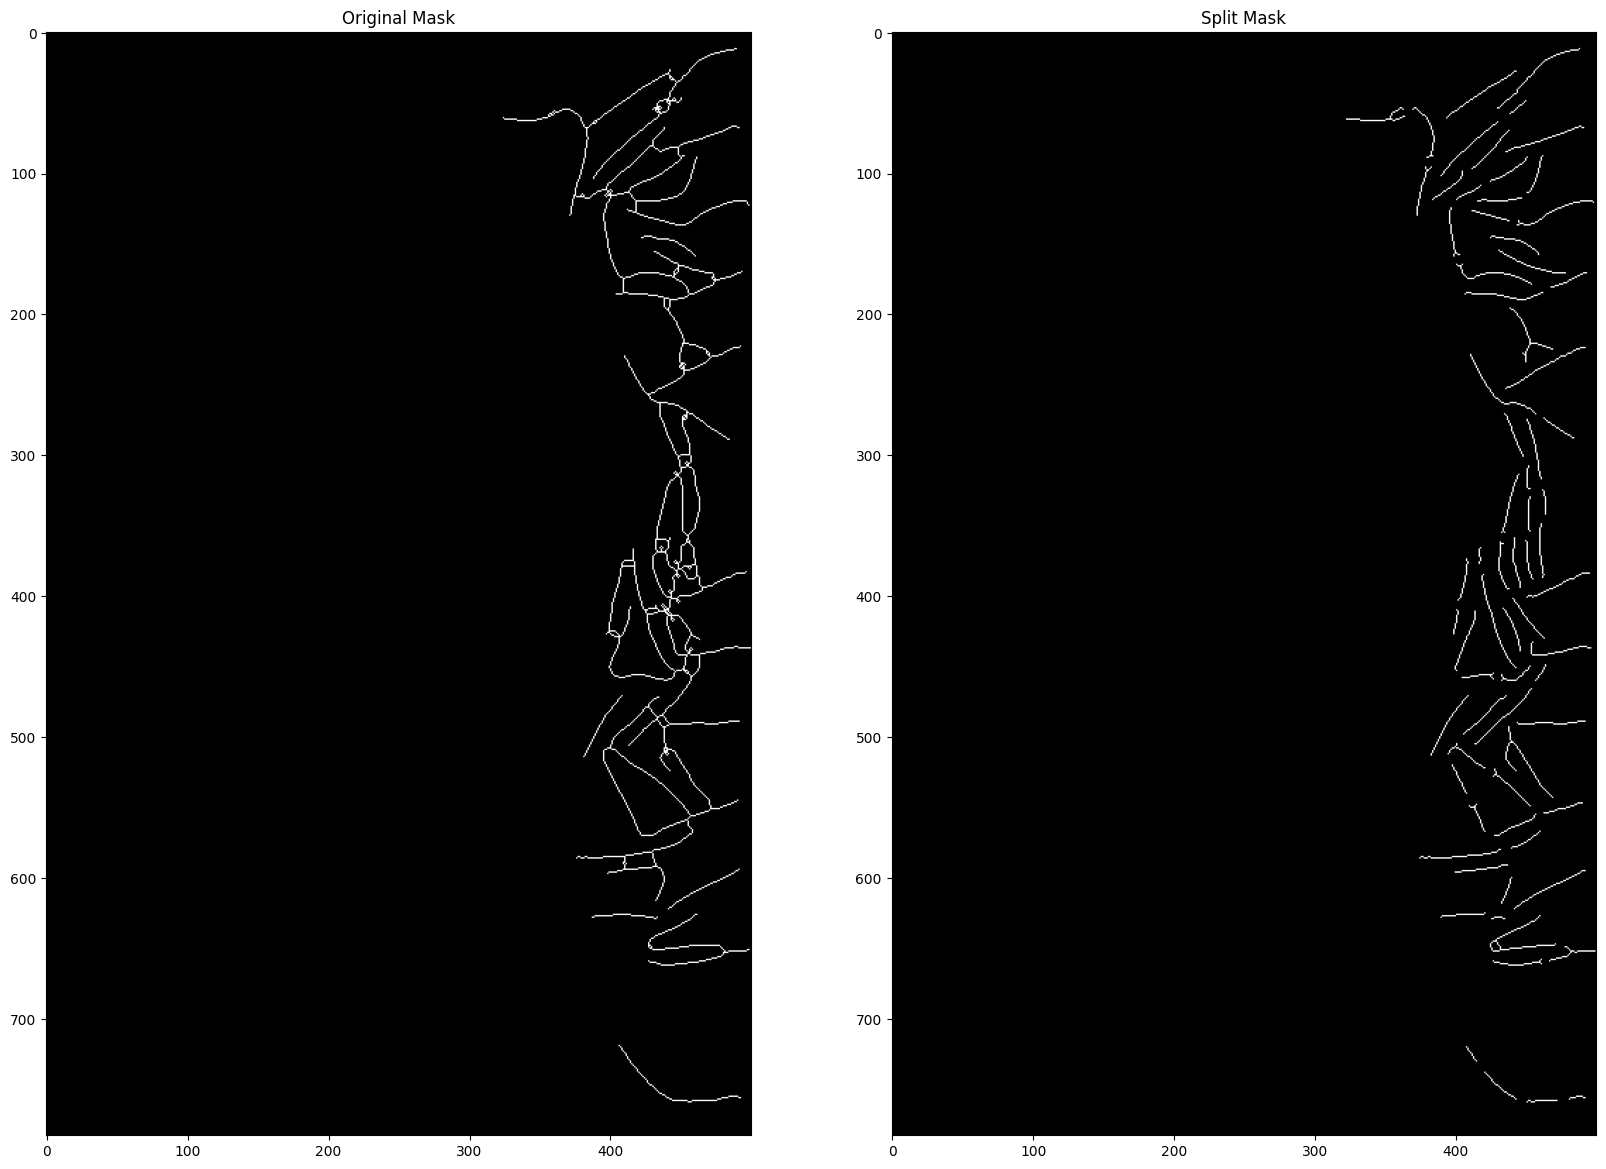

In [ ]:
for i in range(3):
    random_mask = Image.open(random.choice(masks_p))
    random_mask = np.array(random_mask)
    individual_cells = len(np.unique(random_mask))
    split_mask = np.zeros_like(random_mask)

    for j in range(1, individual_cells):
        subset = (random_mask == j)
        if np.sum(subset) == 0:
            continue

        distance = cv2.distanceTransform(subset.astype(np.uint8), cv2.DIST_L2, 5)
        coords = peak_local_max(
            distance,
            labels=subset,
            min_distance=20
        )

        markers = np.zeros_like(distance, dtype=np.int32)
        for idx, (y, x) in enumerate(coords, 1):
            markers[y, x] = idx

        labels = segmentation.watershed(-distance, markers, mask=subset)
        boundaries = find_boundaries(labels, connectivity=1, mode='thick')
        boundaries = binary_dilation(boundaries, iterations=1)
        labels[boundaries] = 0
        labels = labels > 0
        split_mask += labels

f, a = plt.subplots(1,2,figsize=(20,20))
a[0].imshow(skeletonize(random_mask),cmap='gray')
a[0].set_title("Original Mask")
a[1].imshow(skeletonize(split_mask),cmap='gray')
a[1].set_title("Split Mask")


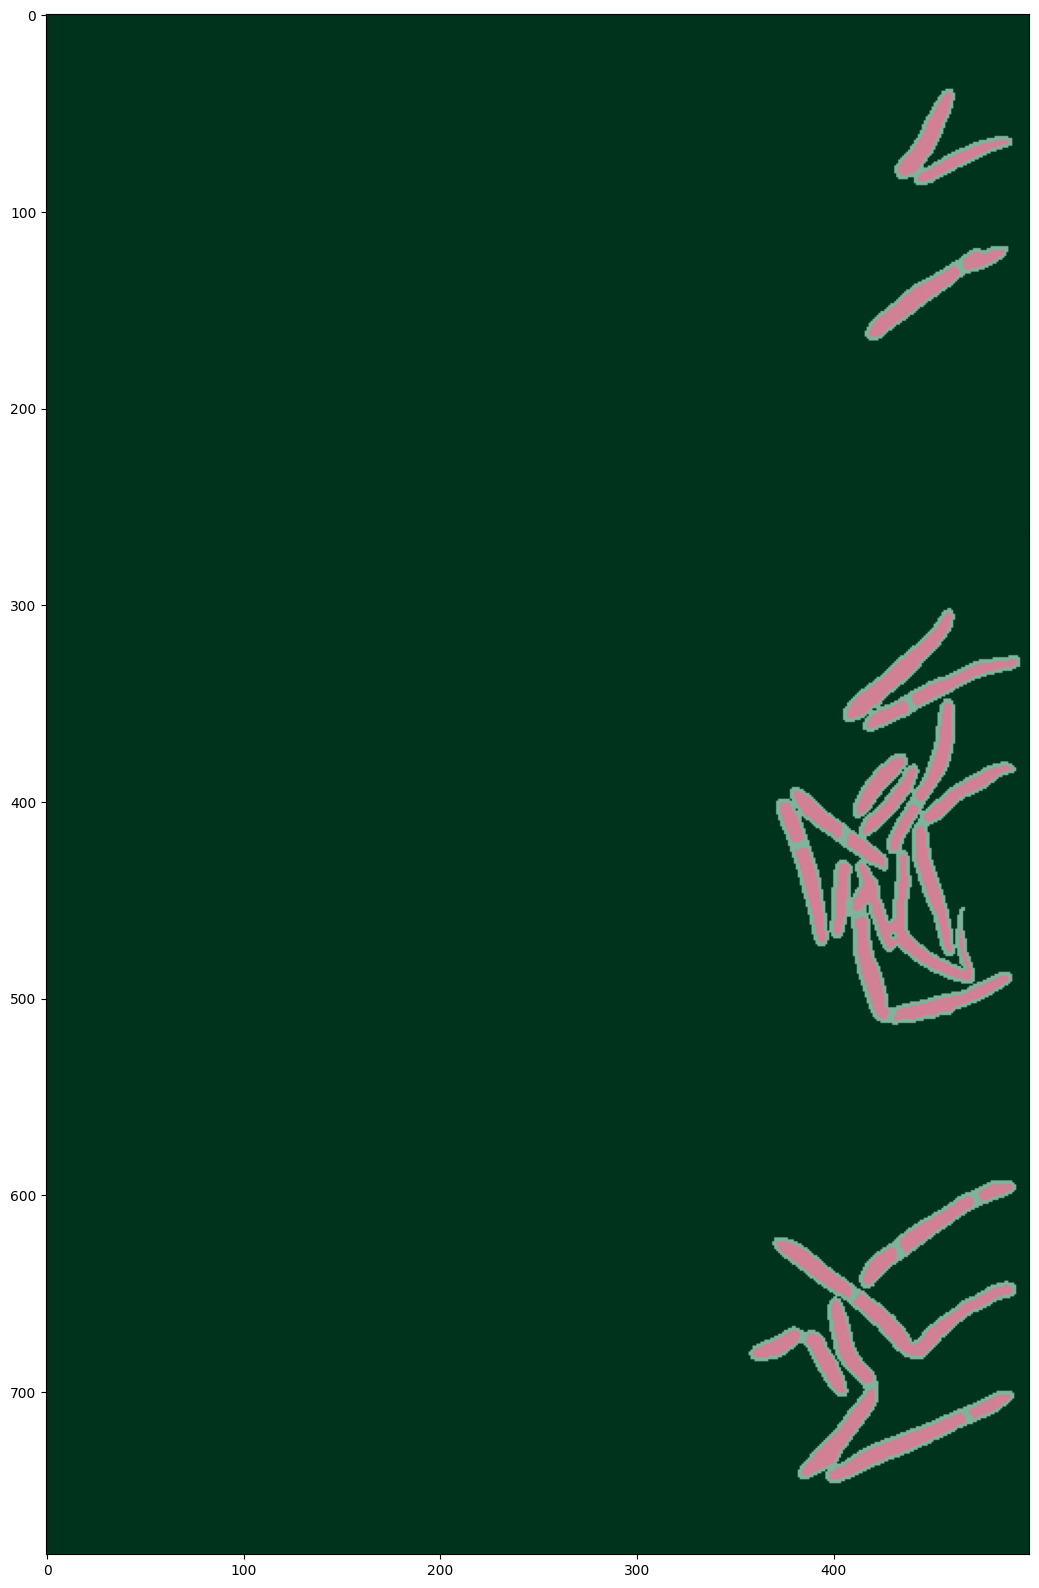

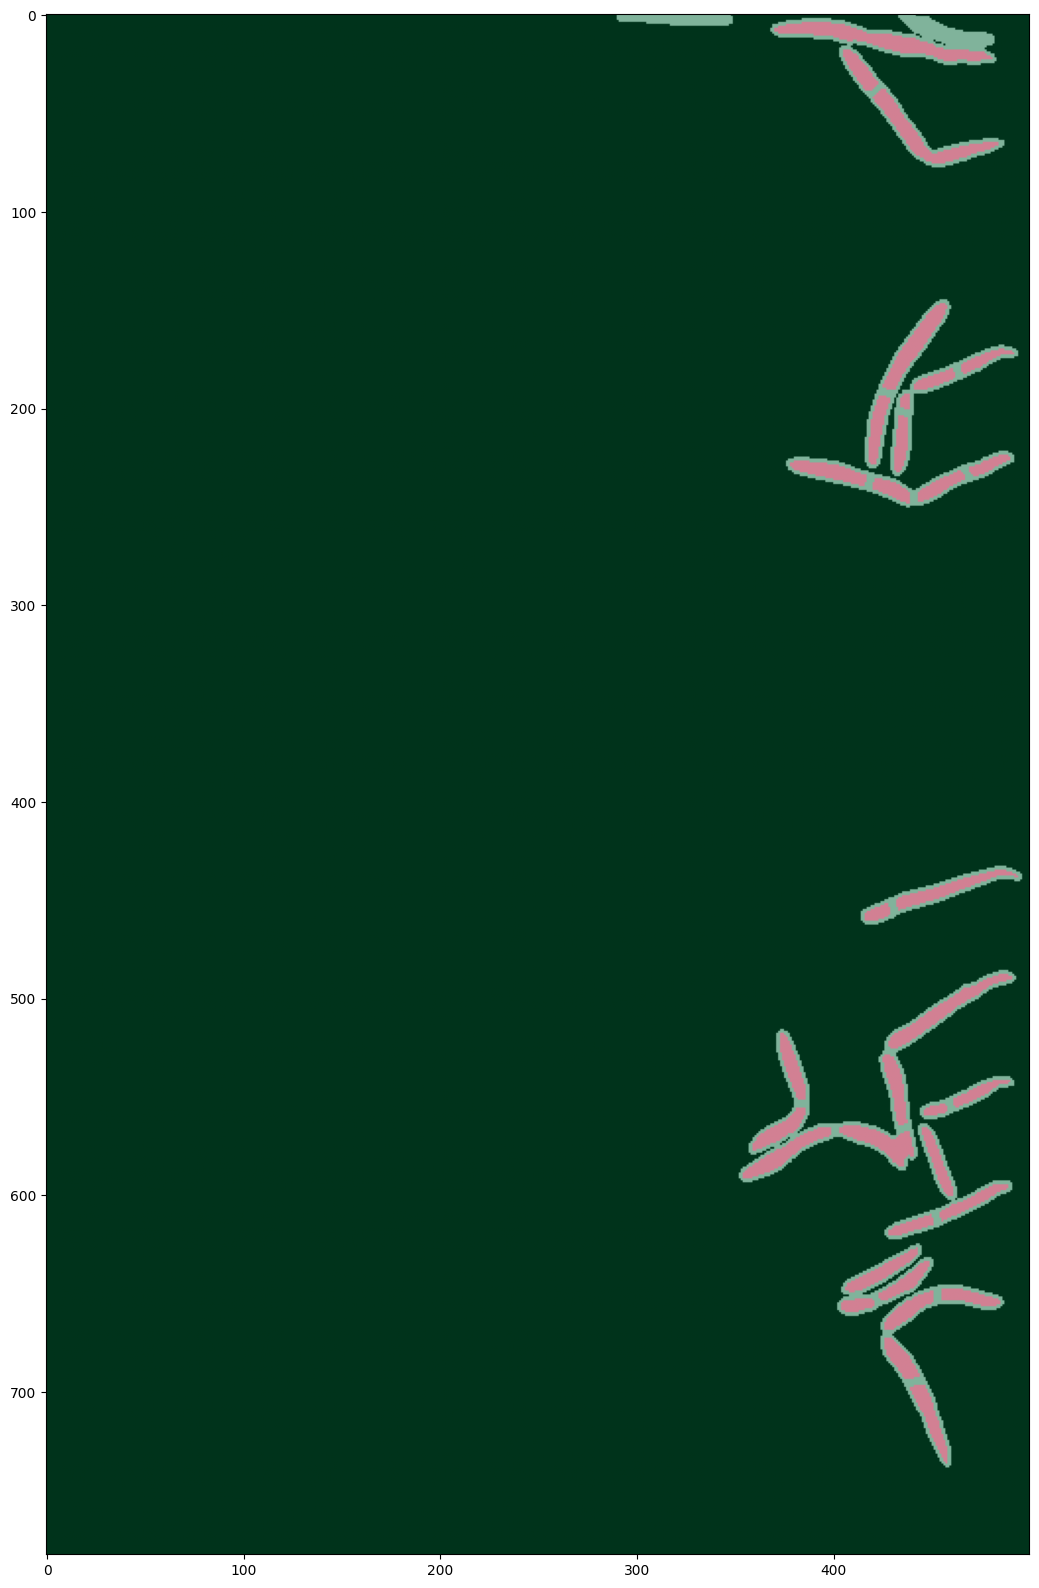

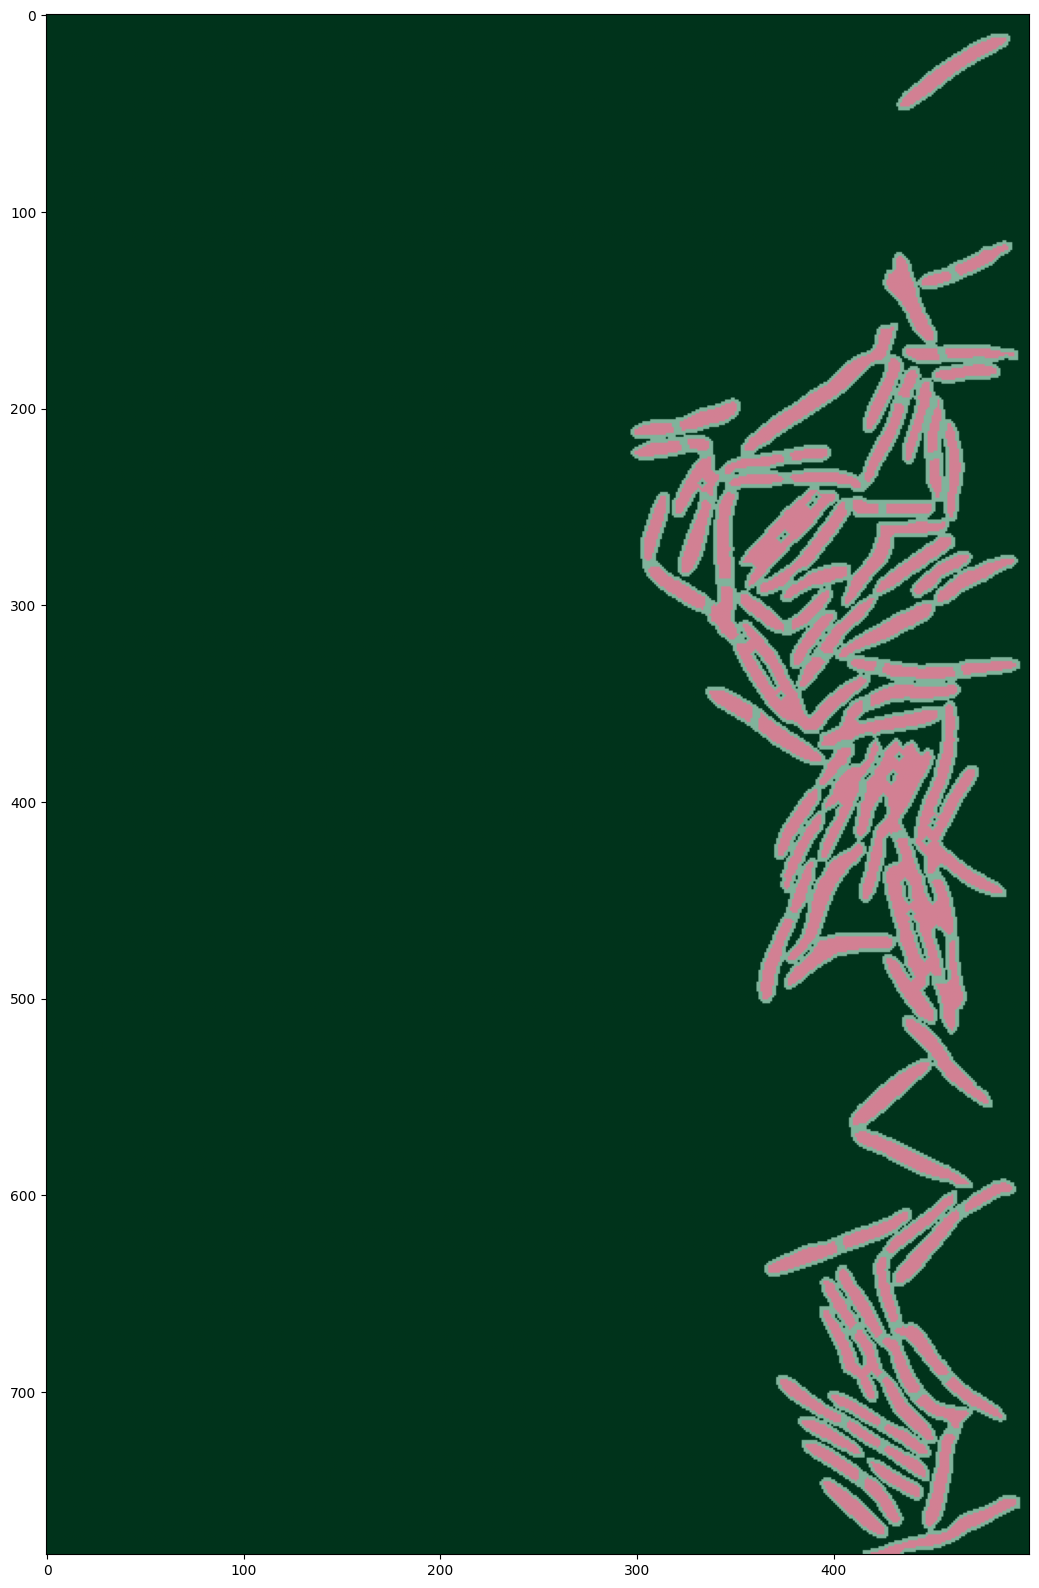

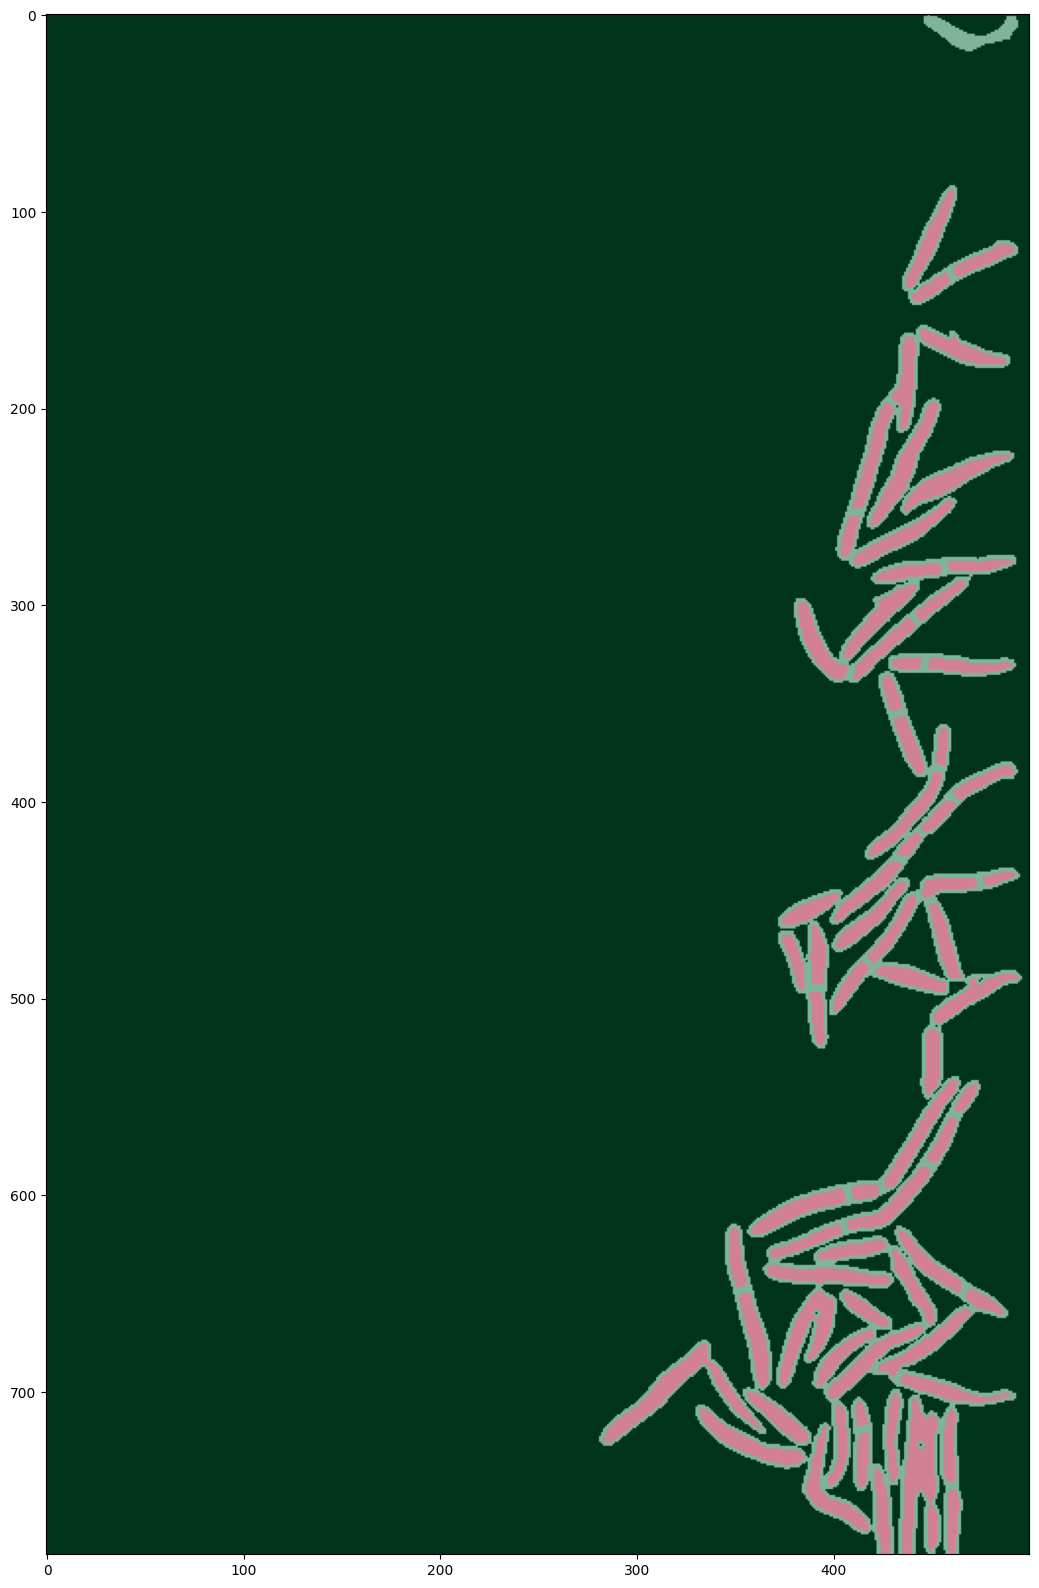

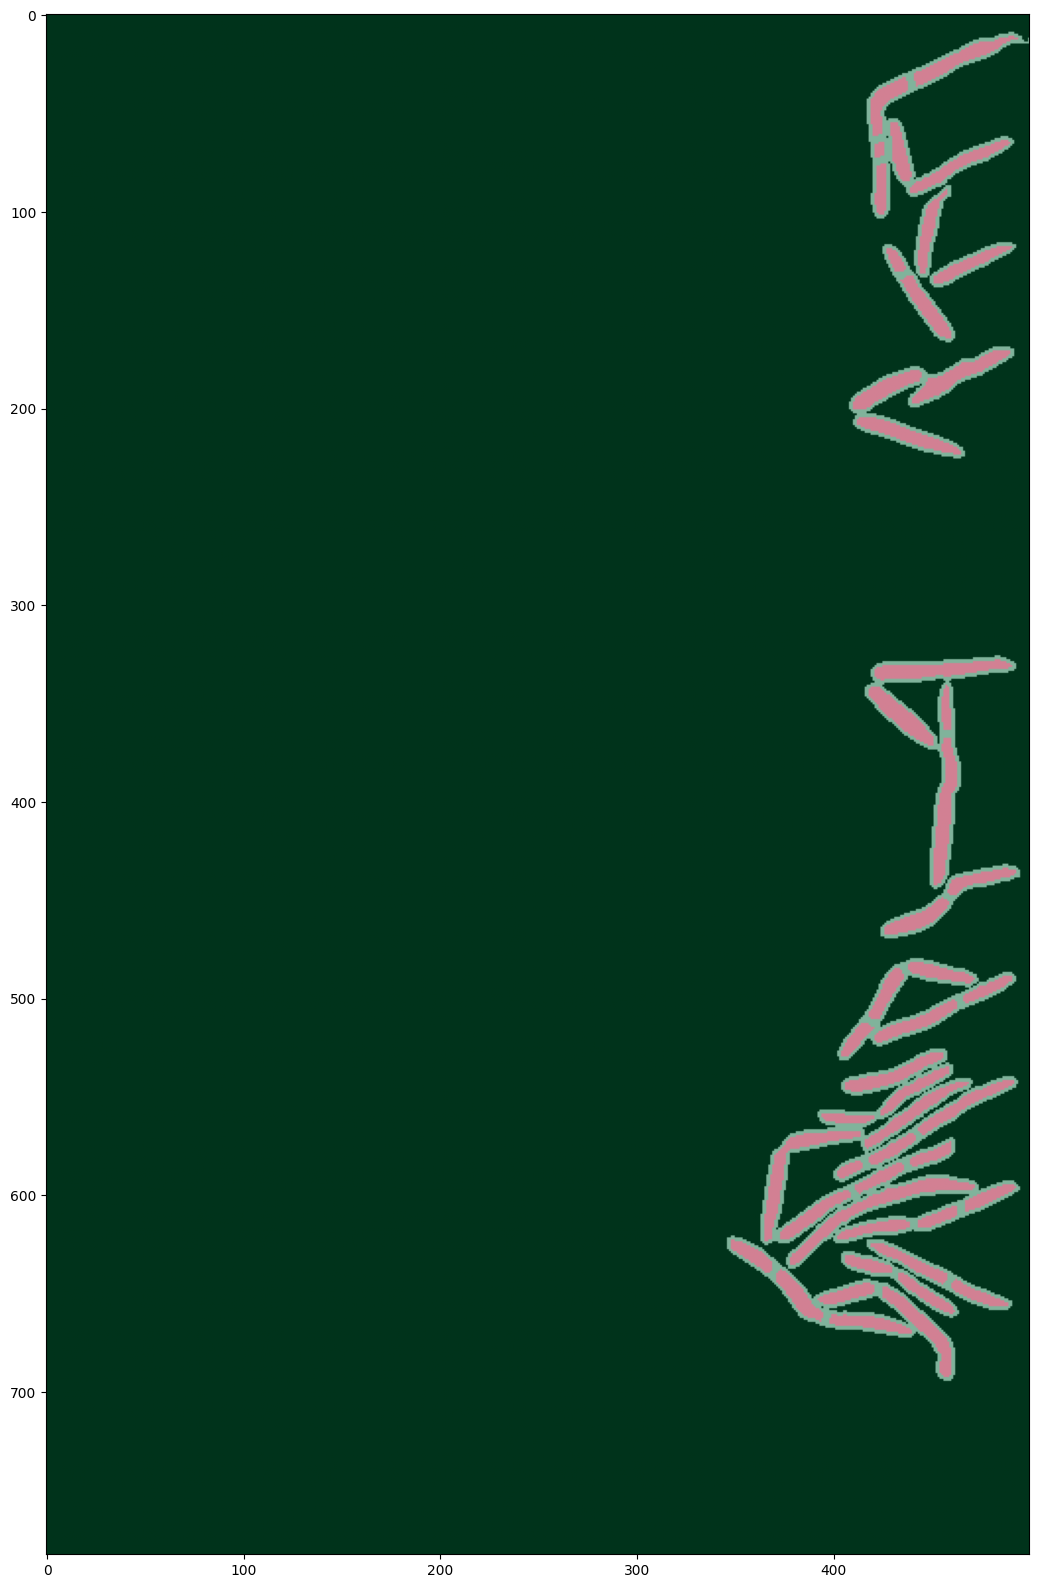

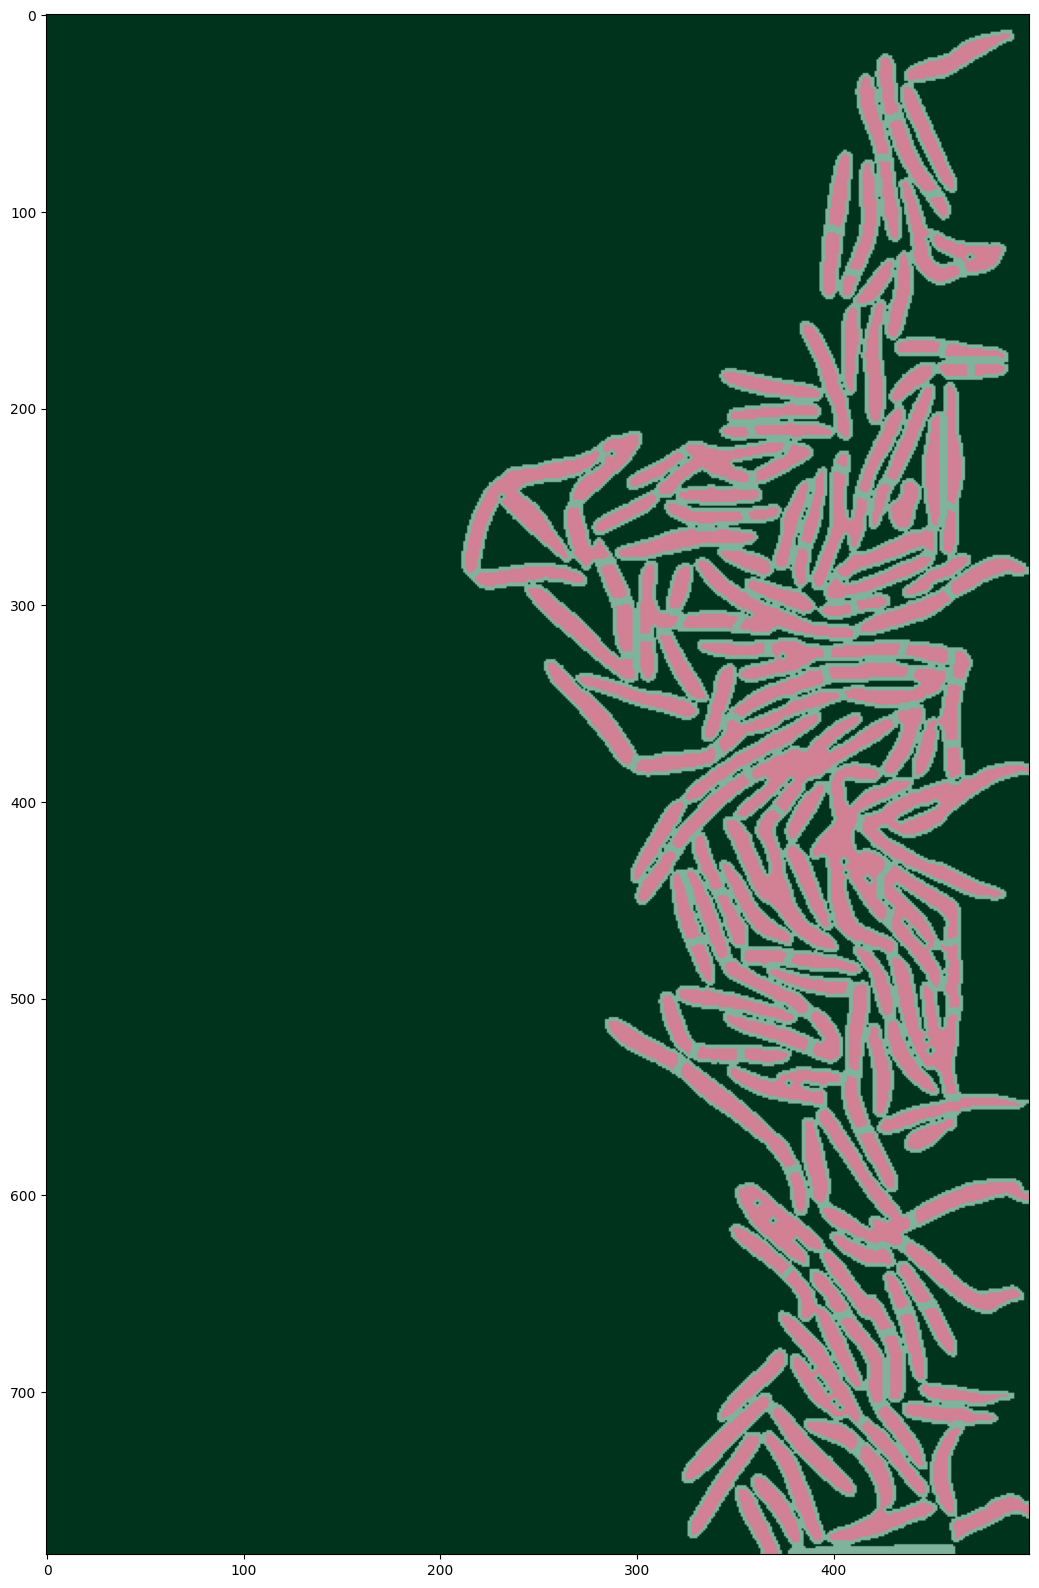

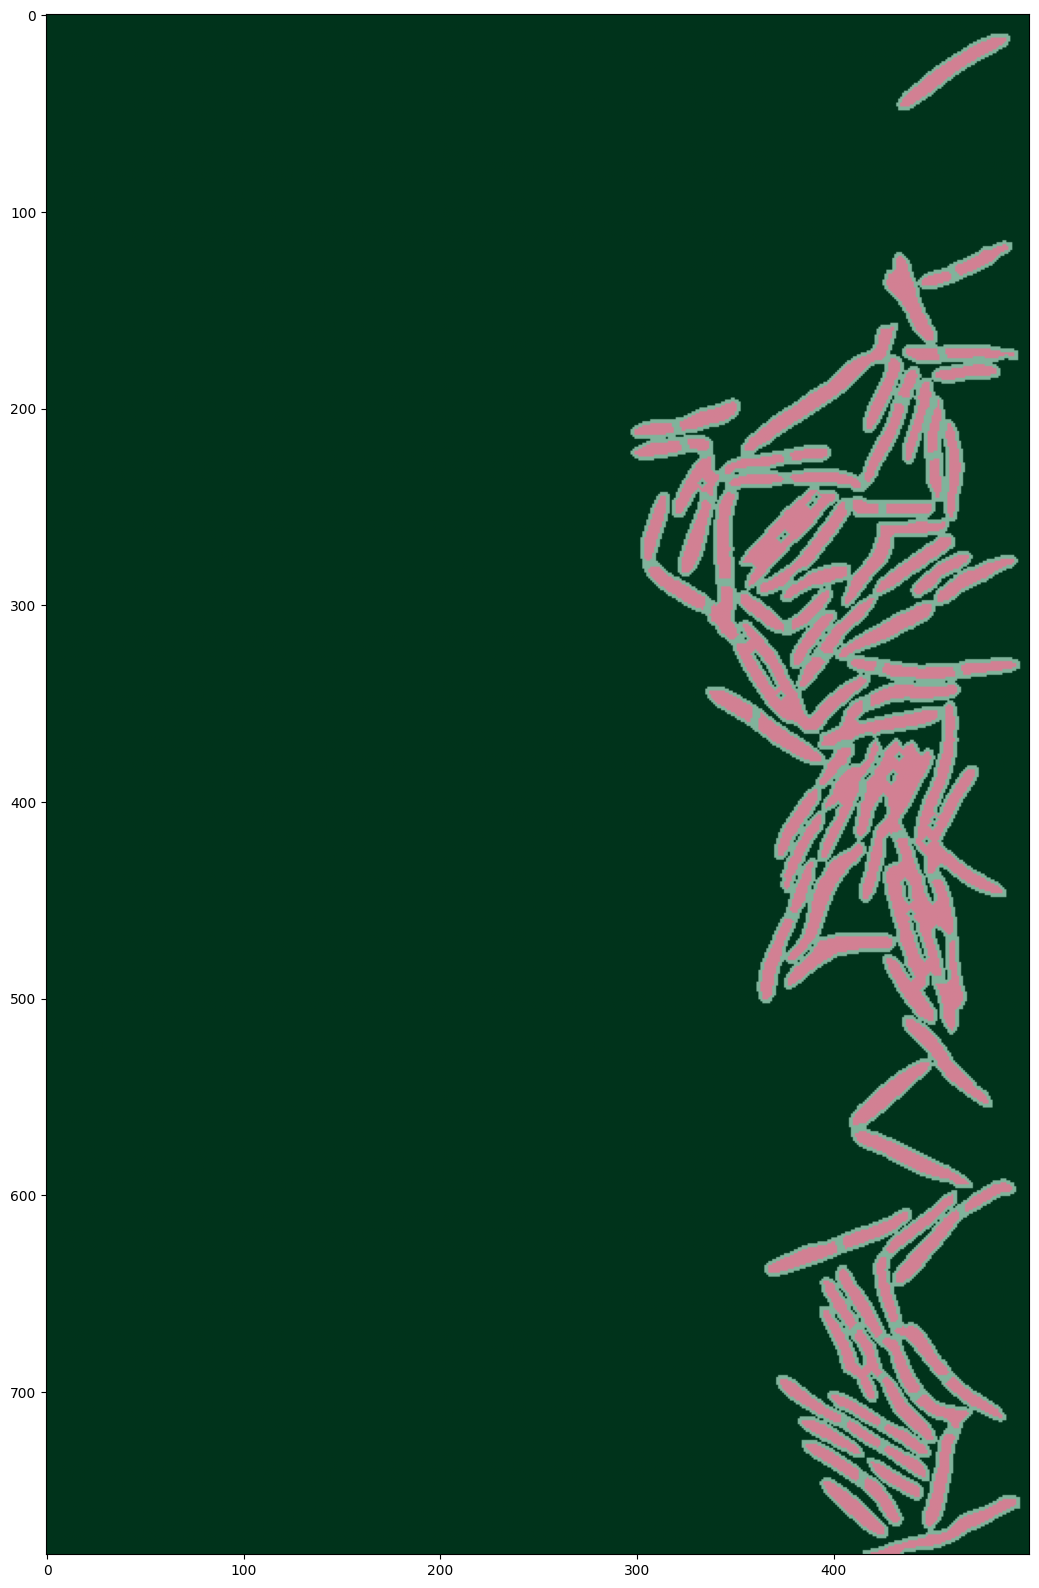

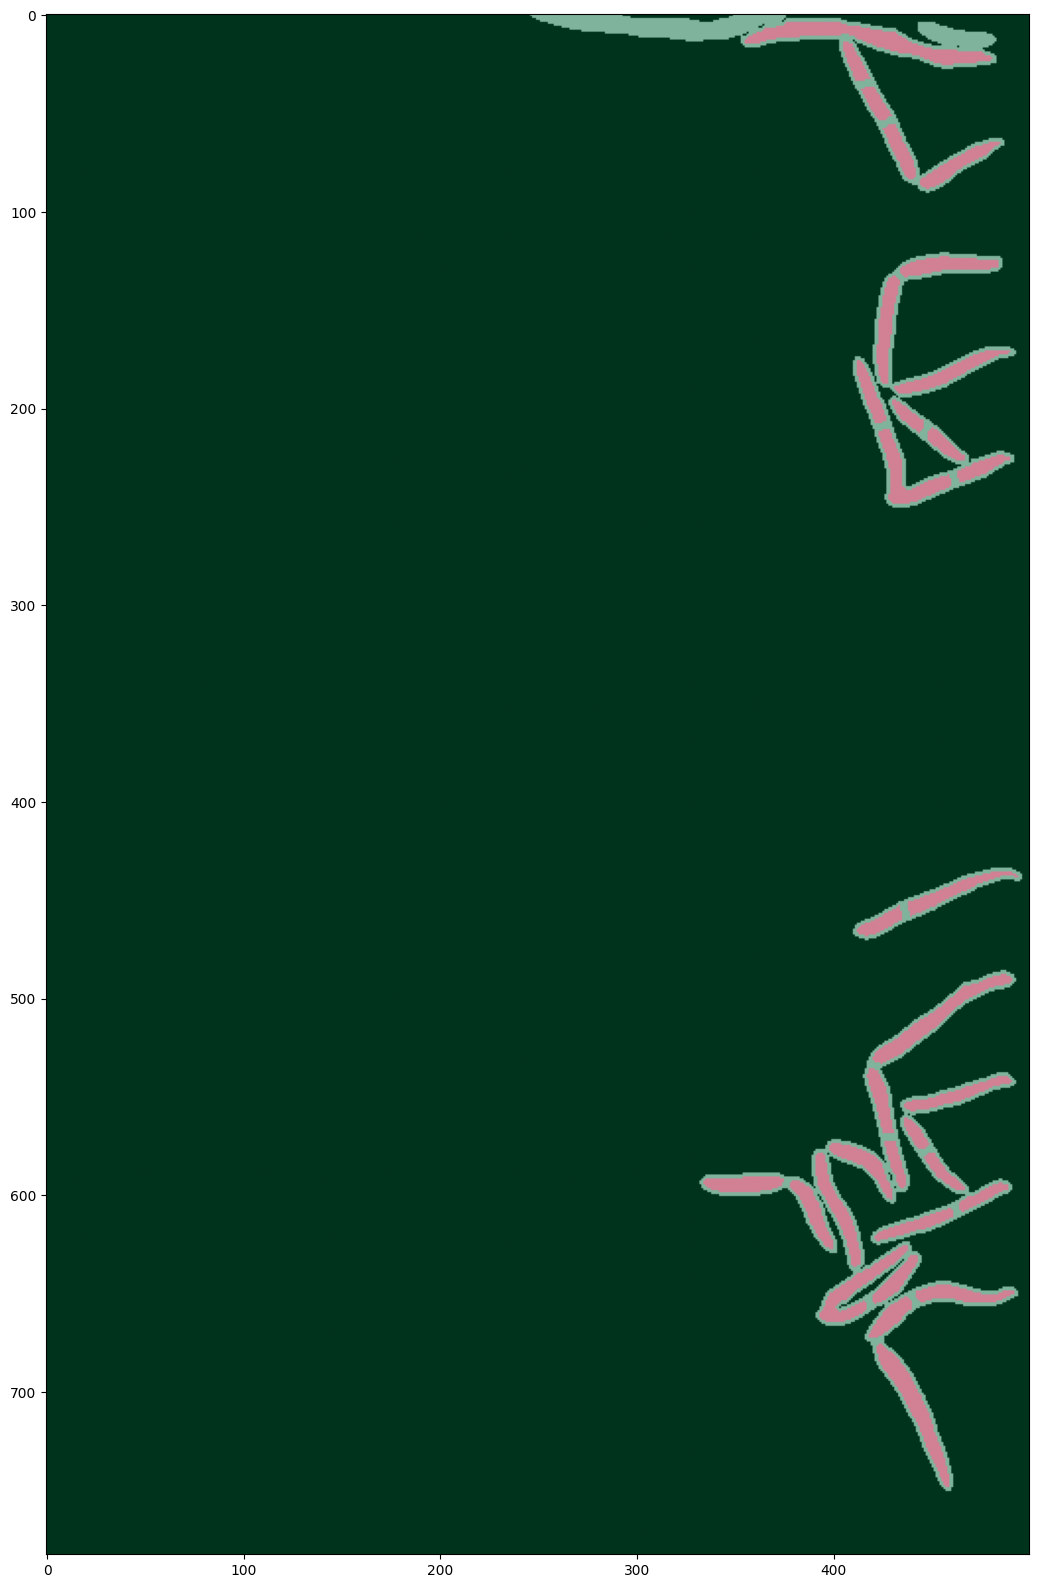

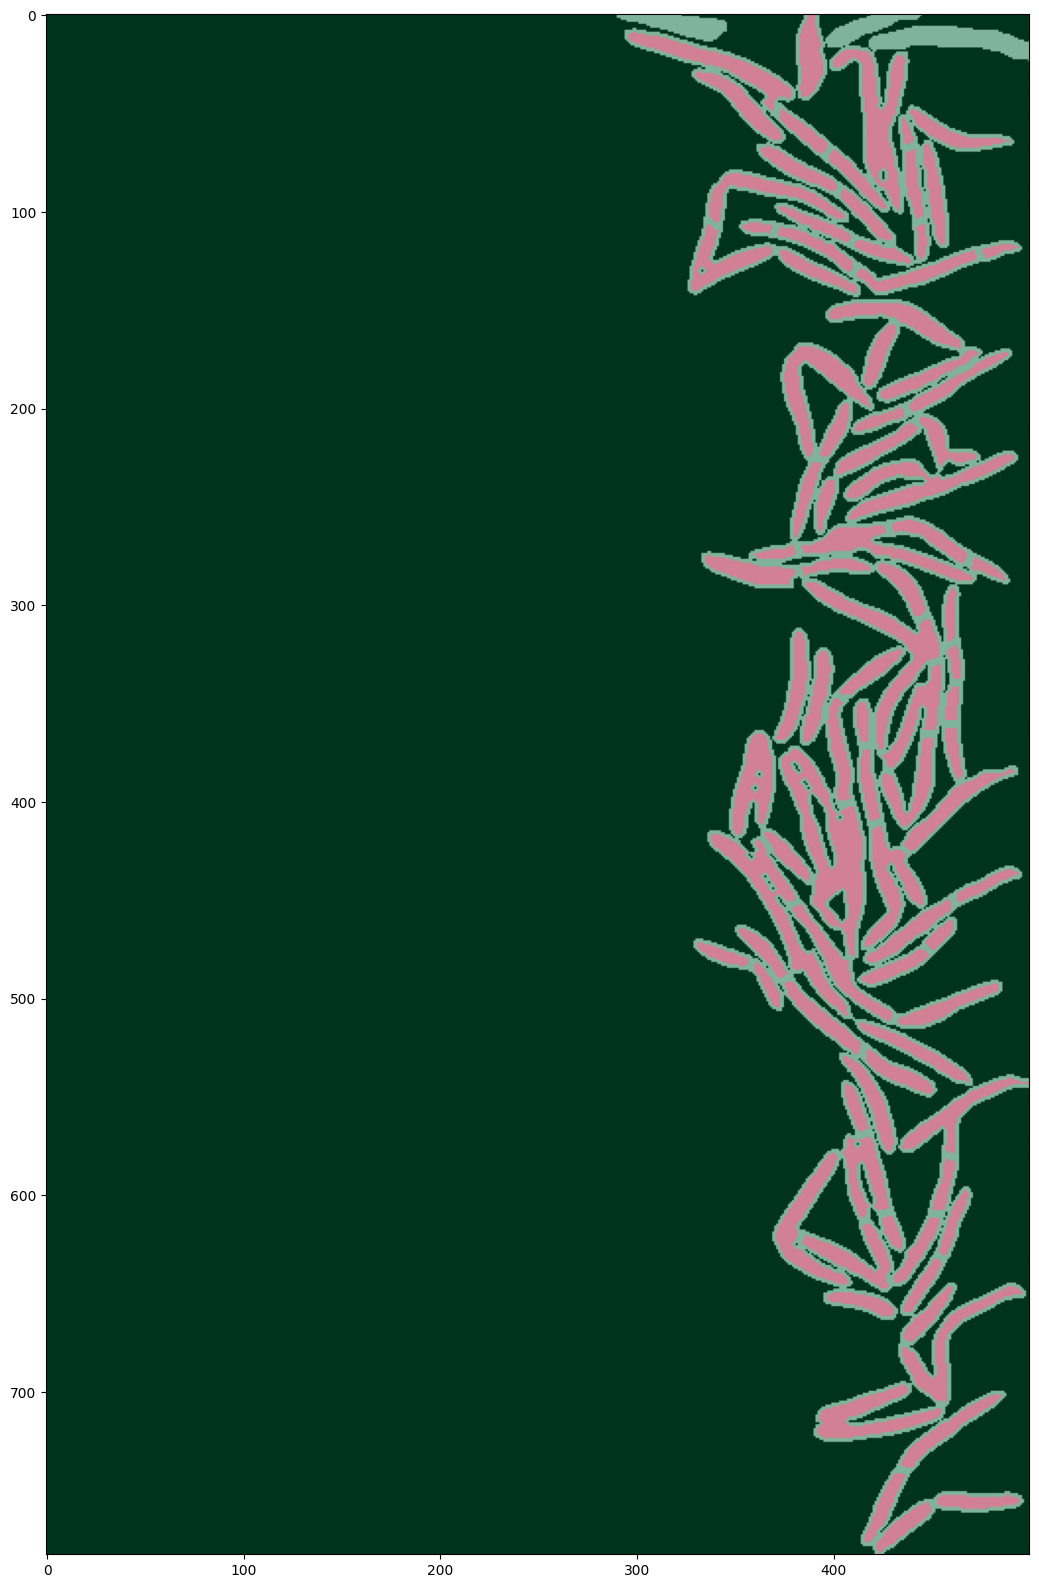

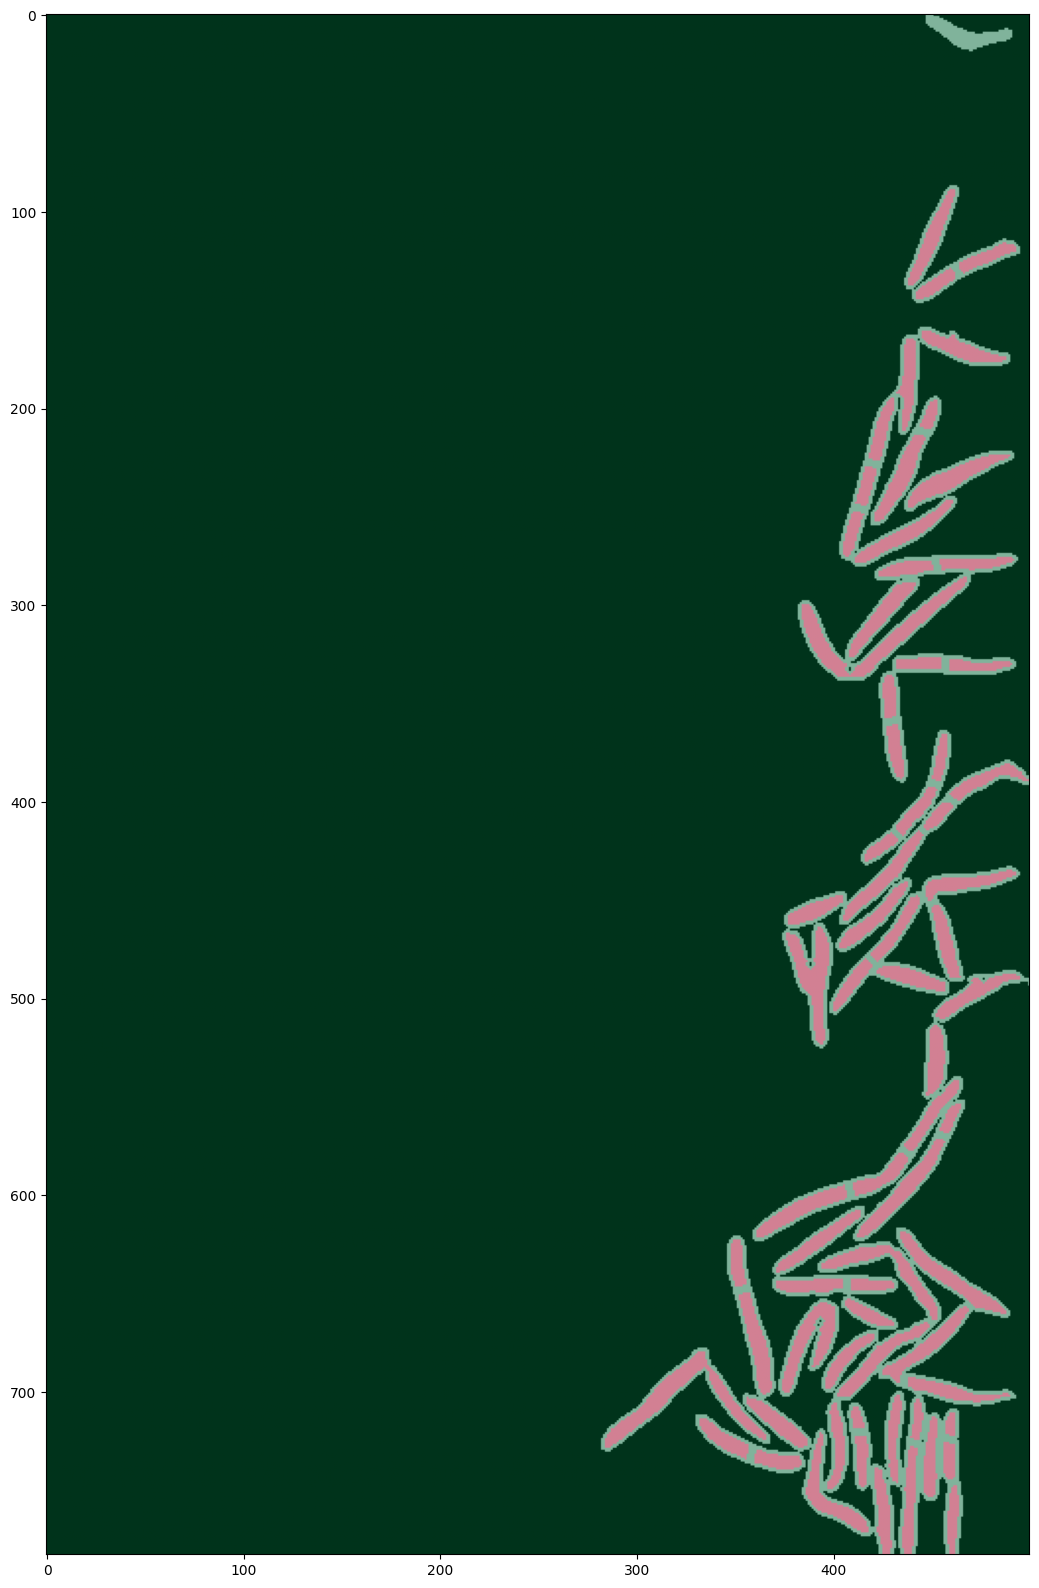

In [ ]:
def clean_mask(mask):
    individual_cells = len(np.unique(mask))
    mask = np.array(mask)
    split_mask = np.zeros_like(mask)

    for j in range(1, individual_cells):
        subset = (mask == j)
        if np.sum(subset) == 0:
            continue

        distance = cv2.distanceTransform(subset.astype(np.uint8), cv2.DIST_L2, 5)
        coords = peak_local_max(
            distance,
            labels=subset,
            min_distance=20
        )

        markers = np.zeros_like(distance, dtype=np.int32)
        for idx, (y, x) in enumerate(coords, 1):
            markers[y, x] = idx

        labels = segmentation.watershed(-distance, markers, mask=subset)
        boundaries = find_boundaries(labels, connectivity=1, mode='thick')
        boundaries = binary_dilation(boundaries, iterations=1)
        labels[boundaries] = 0
        labels = labels > 0
        split_mask += labels

    return split_mask

for i in range(10):
  m = Image.open(random.choice(masks_p))
  cleaned_mask = clean_mask(m)
  m = np.array(m)
  plt.figure(figsize=(20,20))
  plt.imshow(m > 0, cmap='gray')
  plt.imshow(cleaned_mask, cmap='RdYlGn_r', alpha=0.5)
  plt.show()


In [ ]:
output_folder = "cleaned"
os.makedirs(output_folder, exist_ok=True)

for path in masks_p:
    m = Image.open(path)
    cleaned_mask = clean_mask(m)
    filename = os.path.basename(path)
    cleaned_mask = Image.fromarray(cleaned_mask)
    cleaned_mask.save(os.path.join(output_folder, filename))

1
0.015690932311621966


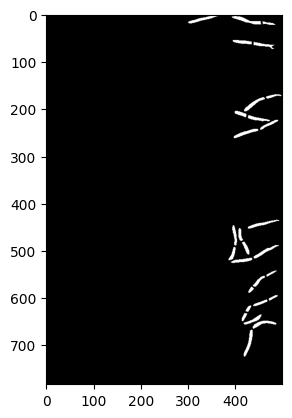

In [ ]:
I = Image.open("/content/cleaned/Pos101_MASK_img_000000010.tif")
I = np.array(I)
print(I.max())
print(I.mean())
plt.imshow(I, cmap='gray')

In [ ]:
import shutil
from google.colab import files

shutil.make_archive('cleaned', 'zip', 'cleaned')  # 'cleaned' is your folder name
files.download('cleaned.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>